In [5]:
# find files recursively
from glob import glob

# parse tb files
from tbparse import SummaryReader

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# searching df rows with np.where()
import numpy as np
import pandas as pd

import re

from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def extract_tb_values(logdir, value_name, print_tags = False):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()
    
    if print_tags:
        print(event_acc.Tags()['scalars'])
        
    if value_name not in event_acc.Tags()['scalars']:
        print("Scalar not found.")
        return [], [], []
    else:
        events = event_acc.Scalars(value_name)
    
    steps = [event.step for event in events]
    values = [event.value for event in events]
    wall_time = [event.wall_time for event in events]
    
    return values, steps, wall_time


def get_df_in_steps(logdir_list, plot_names, value_name, rolling_avg_window = 1, wall_time_avg = False):
    df = pd.DataFrame()
    
    if wall_time_avg: 
        x = "wall_time"
    else:
        x = "steps"
        
    for (file_name, plot_name) in zip(logdir_list, plot_names):
        values, steps, wall_time = extract_tb_values(file_name, value_name)

        if values != []:
            value_dict = {value_name: values, 
                          "steps": steps, 
                          "wall_time": [(time - wall_time[0]) / 60. for time in wall_time]}
            
            temp_df = pd.DataFrame(value_dict)
            
            bin_edges = np.arange(0, temp_df[x].max() + rolling_avg_window, rolling_avg_window, dtype = np.int32)
            temp_df['bin'] = pd.cut(temp_df[x], bins = bin_edges, labels = bin_edges[:-1])

            def weighted_avg(group):
                if not np.isclose(group[x].sum(), 0.):
                    # Calculate the weighted average over the bins weighted by the steps
                    return pd.Series({
                        value_name: np.average(group[value_name], weights = group[x]),
                    })
                else:
                    return None

            temp_df = temp_df.groupby(['bin'], observed = False)[[value_name, "steps", "wall_time", "bin"]].apply(weighted_avg, include_groups = True).reset_index().dropna()
            
            # add missing bins
            all_bins = pd.DataFrame({'bin': bin_edges[:-1]})

            temp_df = pd.merge(all_bins, temp_df, on = 'bin', how = 'left')

            # interpolate missing values
            temp_df[value_name] = temp_df[value_name.replace("reward/", "rollout/")].interpolate()
            
            temp_df = temp_df.rename(columns = {"bin": x})
            temp_df["run"] = np.repeat(plot_name, len(temp_df.index))
            
            df = df._append(temp_df)
        
        print(plot_name + " done!")
     
    return df  


def get_tb_files(env_name, run_name_list):
    tb_files = []
    
    for run_name in run_name_list:
        print(env_name + "/" + run_name + "**")
        for filename in glob((env_name + "/" + run_name + "/events**"), recursive=True):
            tb_files.append(filename)
                
    return tb_files

In [6]:
run_list = [
    # "13_11_30",
    # "14_19_31",
    # "14_20_11",
    "14_20_34",
]

tb_files = get_tb_files("runs", run_list)
tb_files

runs/14_20_34**


['runs/14_20_34/events.out.tfevents.1728930850.LAPTOP-KALTRN6T.613105.0']

In [7]:
df = get_df_in_steps(tb_files, run_list, "train_loss", 10)
df_eval = get_df_in_steps(tb_files, run_list, "eval_loss", 10)

# fig.savefig('plots/training.png', dpi = 300, bbox_inches='tight')

14_20_34 done!
14_20_34 done!


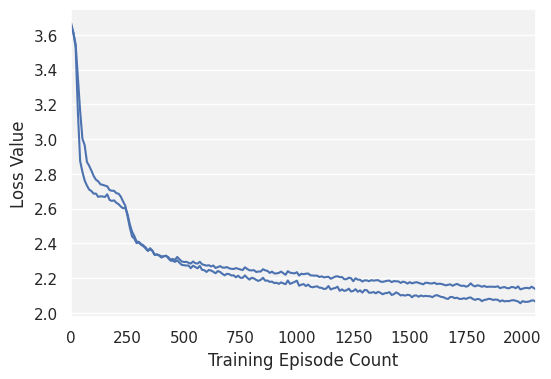

In [8]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df, x = "steps", y = "train_loss", hue = "run", ax = axs)
sns.lineplot(df_eval, x = "steps", y = "eval_loss", hue = "run", ax = axs)
axs.get_legend().remove()
# axs.legend(loc = "upper left", labels = ["train_loss", "_nolegend_", "eval_loss"] , frameon = False)
axs.grid(axis = "y")
# axs.set_ylim(None, 3.0)
axs.set_ylabel('Loss Value')
axs.set_xlabel('Training Episode Count')
# axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)